In [1]:
import spikeinterface.full as si
from probeinterface.plotting import plot_probe, plot_probegroup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from scipy import stats
import os



In [2]:
def ramp_score(ramp_data_vr):
    ramp_data_vr = ramp_data_vr.fillna('None') # replace None types with None strings for ease
    df = pd.DataFrame()
    for cluster_id in np.unique(ramp_data_vr["cluster_id"]):

        outbound = ramp_data_vr[(ramp_data_vr["cluster_id"] == cluster_id) &
                                (ramp_data_vr["trial_type"] == "None") &
                                (ramp_data_vr["hit_miss_try"] == "None") &
                                (ramp_data_vr["track_length"] == "outbound")]["ramp_class"].iloc[0]
        homebound = ramp_data_vr[(ramp_data_vr["cluster_id"] == cluster_id) &
                                 (ramp_data_vr["trial_type"] == "None") &
                                 (ramp_data_vr["hit_miss_try"] == "None") &
                                 (ramp_data_vr["track_length"] == "homebound")]["ramp_class"].iloc[0]
        ramp_class = outbound+homebound
        cluster_df = pd.DataFrame({'cluster_id': [cluster_id],
                                   'outbound_homebound_ramp_class': [ramp_class]})
        df = pd.concat([df, cluster_df], ignore_index=True)
    return df

def calculate_spatial_information(spatial_firing, position_data, track_length):
    if "firing_times_vr" in list(spatial_firing):
        fr_col = "firing_times_vr"
    else:
        fr_col = "firing_times"

    position_heatmap = np.zeros(track_length)
    for x in np.arange(track_length):
        bin_occupancy = len(position_data[(position_data["x_position_cm"] > x) &
                                                (position_data["x_position_cm"] <= x+1)])
        position_heatmap[x] = bin_occupancy
    position_heatmap = position_heatmap*np.diff(position_data["time_seconds"])[-1] # convert to real time in seconds
    occupancy_probability_map = position_heatmap/np.sum(position_heatmap) # Pj

    spatial_information_scores_Ispike = []
    spatial_information_scores_Isec = []
    for cluster_index, cluster_id in enumerate(spatial_firing.cluster_id):
        cluster_df = spatial_firing[(spatial_firing.cluster_id == cluster_id)] # dataframe for that cluster

        mean_firing_rate = len(cluster_df.iloc[0][fr_col])/np.sum(len(position_data)*np.diff(position_data["time_seconds"])[-1]) # λ
        spikes, _ = np.histogram(np.array(cluster_df['x_position_cm'].iloc[0]), bins=track_length, range=(0,track_length))
        rates = spikes/position_heatmap
 
        Isec, Ispike = spatial_info(mean_firing_rate, occupancy_probability_map, rates)

        spatial_information_scores_Ispike.append(Ispike)
        spatial_information_scores_Isec.append(Isec)

    spatial_firing["spatial_information_score_Isec"] = spatial_information_scores_Isec
    spatial_firing["spatial_information_score_Ispike"] = spatial_information_scores_Ispike
    return spatial_firing

def spatial_info(mrate, occupancy_probability_map, rates):
    Isec = np.sum(occupancy_probability_map * rates * np.log2((rates / mrate) + 0.0001))
    Ispike = Isec / mrate
    return Isec, Ispike


In [3]:

def remove_all_from_ax(ax):
    for spine in ax.spines.values():
        spine.set_visible(False) 
    ax.tick_params(left=False, bottom=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax

## M21 ramp cells

In [6]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations
of_session_base_names = ["M21_D26_2024-05-28_16-35-31_OF1", "M21_D23_2024-05-25_16-07-17_OF1", "M21_D25_2024-05-27_15-35-57_OF1", "M21_D24_2024-05-26_15-58-23_OF1"]
vr_session_base_names = ["M21_D26_2024-05-28_17-04-41_VR1", "M21_D23_2024-05-25_16-54-12_VR1", "M21_D25_2024-05-27_16-00-30_VR1", "M21_D24_2024-05-26_16-35-19_VR1"]
 
M21_master_data = pd.DataFrame()
for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
    vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    ramp_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/ramp_classifications.pkl"
    of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"

    spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]
    spike_data_of = pd.read_pickle(of_path)
    ramp_data_vr = pd.read_pickle(ramp_path)
    ramp_data_vr = ramp_score(ramp_data_vr)
    spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")
    spike_data = pd.merge(spike_data, ramp_data_vr, on="cluster_id")
    position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
    processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
    position_data = pd.read_csv(position_path)
    processed_position_data = pd.read_pickle(processed_position_path)

    spike_data = calculate_spatial_information(spike_data, position_data, track_length=200)

    sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
    ulc = sorting_analyzer.get_extension("unit_locations")
    unit_locations = ulc.get_data(outputs="by_unit")

    spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
    spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
    spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])
    M21_master_data = pd.concat([M21_master_data, spike_data])

    print(f"for basename {vr_name}")
    n_grid_cells =len(spike_data[spike_data["grid_score"]> 0.3])
    percentage_grid_cells = 100*n_grid_cells/len(spike_data)
    print(f"n grid cells: {n_grid_cells}, %: {percentage_grid_cells}")
    

fig, ax = plt.subplots(figsize=(10, 6))
probe_group = sorting_analyzer.get_probegroup()
plot_probegroup(probe_group, ax=ax, probe_shape_kwargs={"alpha":0.5,"color":"lightgrey"},
                contacts_kargs={"alpha":0.0})
for ramp_class, c, m, in zip(["UNUN", "--", "-+", "-UN", "++", "+-", "+UN"], 
                             [ "grey", "palevioletred", "palevioletred", "palevioletred", "palegreen", "palegreen", "palegreen"], 
                             ["x", "o", "^", "+", "o", "^", "+"]):
    subset = M21_master_data[M21_master_data['outbound_homebound_ramp_class'] == ramp_class]
    ax.scatter(subset['unit_location_x'], subset['unit_location_y'], label=ramp_class, zorder=2, alpha=0.5, marker=m, color=c)
ax.set_xlim(-200, 1700)
ax.set_ylim(-200, 3000)
ax.set_title("all cells")
#ax = remove_all_from_ax(ax)
plt.legend()
plt.show()

### curate
print(f"pre-curation M21: {len(M21_master_data)}")
M21_master_data = M21_master_data[(M21_master_data["snr_x"] > 1) & (M21_master_data["mean_firing_rate_x"] > 0.5) & (M21_master_data["rp_contamination_x"] < 0.9)]
print(f"post-curation M21: {len(M21_master_data)}")


fig, ax = plt.subplots(figsize=(10, 6))
probe_group = sorting_analyzer.get_probegroup()
plot_probegroup(probe_group, ax=ax, probe_shape_kwargs={"alpha":0.5,"color":"lightgrey"},
                contacts_kargs={"alpha":0.0})

grid_data =M21_master_data[(M21_master_data["grid_score"]>0.3)]
for ramp_class, c, m, in zip(["UNUN", "--", "-+", "-UN", "++", "+-", "+UN"], 
                             [ "grey", "palevioletred", "palevioletred", "palevioletred", "palegreen", "palegreen", "palegreen"], 
                             ["x", "o", "^", "+", "o", "^", "+"]):
    subset = grid_data[grid_data['outbound_homebound_ramp_class'] == ramp_class]
    ax.scatter(subset['unit_location_x'], subset['unit_location_y'], label=ramp_class, zorder=2, alpha=0.5, marker=m, color=c)
ax.set_xlim(-200, 1700)
ax.set_ylim(-200, 3000)
ax.set_title("grid cells")
#ax = remove_all_from_ax(ax)
plt.legend()
plt.show()


## M20 ramp cells

pre-curation M20: 963
post-curation M20: 414


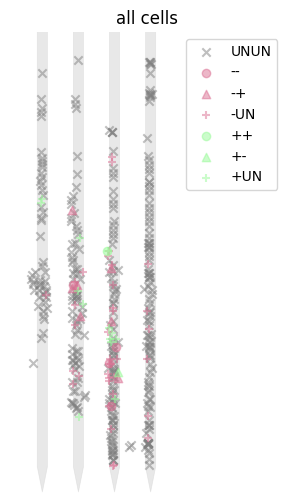

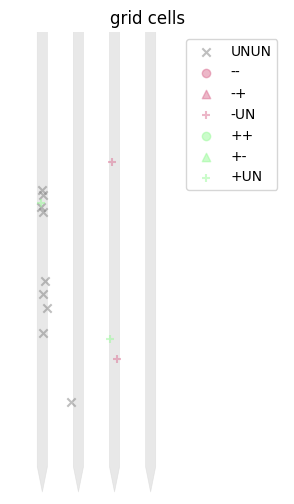

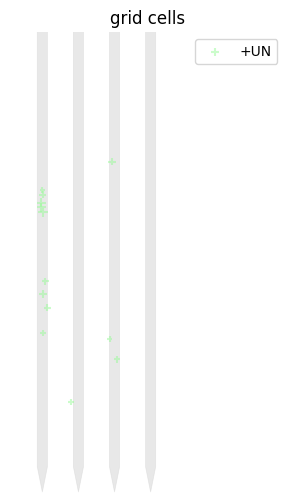

In [ ]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations

of_session_base_names = [
                      "M20_D23_2024-05-25_14-10-43_OF1",
                      "M20_D24_2024-05-26_14-17-55_OF1", 
                      "M20_D25_2024-05-27_13-57-19_OF1",
                      "M20_D26_2024-05-28_14-31-11_OF1"]
vr_session_base_names = [
                      "M20_D23_2024-05-25_14-54-34_VR1",
                      "M20_D24_2024-05-26_14-49-32_VR1", 
                      "M20_D25_2024-05-27_14-24-21_VR1",
                      "M20_D26_2024-05-28_15-18-55_VR1"]

M20_master_data = pd.DataFrame()
for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
    vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    ramp_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/ramp_classifications.pkl"
    of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"

    spike_data_vr = pd.read_pickle(vr_path)
    spike_data_of = pd.read_pickle(of_path)
    ramp_data_vr = pd.read_pickle(ramp_path)
    ramp_data_vr = ramp_score(ramp_data_vr)
    spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")
    spike_data = pd.merge(spike_data, ramp_data_vr, on="cluster_id")


    sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
    ulc = sorting_analyzer.get_extension("unit_locations")
    unit_locations = ulc.get_data(outputs="by_unit")

    spike_data['unit_location_x'] = spike_data.index.map(lambda unit: unit_locations[unit][0])
    spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
    spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])
    M20_master_data = pd.concat([M20_master_data, spike_data])

    print(f"for basename {vr_name}")
    n_grid_cells =len(spike_data[spike_data["grid_score"]> 0.3])
    percentage_grid_cells = 100*n_grid_cells/len(spike_data)
    print(f"n grid cells: {n_grid_cells}, %: {percentage_grid_cells}")

### curate
print(f"pre-curation M20: {len(M20_master_data)}")
M20_master_data = M20_master_data[(M20_master_data["snr_x"] > 1) & (M20_master_data["mean_firing_rate_x"] > 0.5) & (M20_master_data["rp_contamination_x"] < 0.9)]
print(f"post-curation M20: {len(M20_master_data)}")
fig, ax = plt.subplots(figsize=(10, 6))
probe_group = sorting_analyzer.get_probegroup()
plot_probegroup(probe_group, ax=ax, probe_shape_kwargs={"alpha":0.5,"color":"lightgrey"},
                contacts_kargs={"alpha":0.0})
for ramp_class, c, m, in zip(["UNUN", "--", "-+", "-UN", "++", "+-", "+UN"], 
                             [ "grey", "palevioletred", "palevioletred", "palevioletred", "palegreen", "palegreen", "palegreen"], 
                             ["x", "o", "^", "+", "o", "^", "+"]):
    subset = M20_master_data[M20_master_data['outbound_homebound_ramp_class'] == ramp_class]
    ax.scatter(subset['unit_location_x'], subset['unit_location_y'], label=ramp_class, zorder=2, alpha=0.5, marker=m, color=c)
ax.set_xlim(-200, 1700)
ax.set_ylim(-200, 3000)
ax.set_title("all cells")
ax = remove_all_from_ax(ax)
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
probe_group = sorting_analyzer.get_probegroup()
plot_probegroup(probe_group, ax=ax, probe_shape_kwargs={"alpha":0.5,"color":"lightgrey"},
                contacts_kargs={"alpha":0.0})

grid_data =M20_master_data[(M20_master_data["grid_score"]>0.3)]
for ramp_class, c, m, in zip(["UNUN", "--", "-+", "-UN", "++", "+-", "+UN"], 
                             [ "grey", "palevioletred", "palevioletred", "palevioletred", "palegreen", "palegreen", "palegreen"], 
                             ["x", "o", "^", "+", "o", "^", "+"]):
    subset = grid_data[grid_data['outbound_homebound_ramp_class'] == ramp_class]
    ax.scatter(subset['unit_location_x'], subset['unit_location_y'], label=ramp_class, zorder=2, alpha=0.5, marker=m, color=c)
ax.set_xlim(-200, 1700)
ax.set_ylim(-200, 3000)
ax.set_title("grid cells")
ax = remove_all_from_ax(ax)
plt.legend()
plt.show()




In [ ]:
## print ramp stats
M21_ramp_data = M21_master_data[np.isin(M21_master_data["outbound_homebound_ramp_class"], [ "--", "-+", "-UN", "++", "+-", "+UN"])]
print(f'M21 n ramp cells {len(M21_ramp_data)}')
print(f'M21 % ramp cells {100*len(M21_ramp_data)/len(M21_master_data)}')
n_grid_cells =len(M21_master_data[M21_master_data["grid_score"]> 0.3])
percentage_grid_cells = 100*n_grid_cells/len(M21_master_data)
print(f"n grid cells: {n_grid_cells}, %: {percentage_grid_cells}")

M20_ramp_data = M20_master_data[np.isin(M20_master_data["outbound_homebound_ramp_class"], [ "--", "-+", "-UN", "++", "+-", "+UN"])]
print(f'M20 n ramp cells {len(M20_ramp_data)}')
print(f'M20 % ramp cells {100*len(M20_ramp_data)/len(M20_master_data)}')

n_grid_cells =len(M20_master_data[M20_master_data["grid_score"]> 0.3])
percentage_grid_cells = 100*n_grid_cells/len(M20_master_data)
print(f"n grid cells: {n_grid_cells}, %: {percentage_grid_cells}")

M21 n ramp cells 441
M21 % ramp cells 41.21495327102804
n grid cells: 32, %: 2.9906542056074765
M20 n ramp cells 62
M20 % ramp cells 14.97584541062802
n grid cells: 13, %: 3.140096618357488


In [5]:
M21_entorhinal_data = M21_master_data[M21_master_data["unit_location_y"] < 2200]
M21_visual_data = M21_master_data[M21_master_data["unit_location_y"] > 2200]
print(f'M21 visual n ramp cells {len(M21_visual_data[M21_visual_data["outbound_homebound_ramp_class"] != "UNUN"])}')
print(f'M21 visual % ramp cells {100*len(M21_visual_data[M21_visual_data["outbound_homebound_ramp_class"] != "UNUN"])/len(M21_visual_data)}')
print(f'M21 ento n ramp cells {len(M21_entorhinal_data[M21_entorhinal_data["outbound_homebound_ramp_class"] != "UNUN"])}')
print(f'M21 ento % ramp cells {100*len(M21_entorhinal_data[M21_entorhinal_data["outbound_homebound_ramp_class"] != "UNUN"])/len(M21_entorhinal_data)}')

M20_entorhinal_data = M20_master_data[M20_master_data["unit_location_y"] < 2200]
M20_visual_data = M20_master_data[M20_master_data["unit_location_y"] > 2200]
print(f'M21 visual n ramp cells {len(M20_visual_data[M20_visual_data["outbound_homebound_ramp_class"] != "UNUN"])}')
print(f'M21 visual % ramp cells {100*len(M20_visual_data[M20_visual_data["outbound_homebound_ramp_class"] != "UNUN"])/len(M20_visual_data)}')
print(f'M21 ento n ramp cells {len(M20_entorhinal_data[M20_entorhinal_data["outbound_homebound_ramp_class"] != "UNUN"])}')
print(f'M21 ento % ramp cells {100*len(M20_entorhinal_data[M20_entorhinal_data["outbound_homebound_ramp_class"] != "UNUN"])/len(M20_entorhinal_data)}')


M21 visual n ramp cells 34
M21 visual % ramp cells 37.77777777777778
M21 ento n ramp cells 125
M21 ento % ramp cells 37.993920972644375


NameError: name 'M20_master_data' is not defined

In [ ]:
M20_master_data["mouse_id"] = "M20"
M21_master_data["mouse_id"] = "M21"
master_data = pd.concat([M20_master_data, M21_master_data], ignore_index=True)
for score_col, threshold in zip(["grid_score",  "speed_score",  "border_score",  "hd_score"], [0.3, 0.3, 0.5, 0.3]):

    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2,0.5], height_ratios=[0.5,2])
    ax = fig.add_subplot(gs[1, 0])
    ax.set_title(score_col)
    plot_probegroup(probe_group, ax=ax, probe_shape_kwargs={"alpha":0.5,"color":"lightgrey"},contacts_kargs={"alpha":0.0})
    master_data_tmp = master_data.dropna(subset=[score_col])
 
    for mouse_id, c in zip(["M20", "M21"], ["blue", "pink"]):
        scores = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id][score_col] 

        x = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id]['unit_location_x'][scores>threshold]
        y = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id]['unit_location_y'][scores>threshold]
        z = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id]['unit_location_z'][scores>threshold]
        s = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id][score_col][scores>threshold]*100
        scatter = ax.scatter(x, y, s=s, c=c, alpha=0.5)

    ax.set_xlim(-200, 1000)
    ax.set_ylim(-200, 3000)
    plt.tight_layout()
    plt.show()

## M21

In [ ]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations
of_session_base_names = ["M21_D15_2024-05-15_11-22-21_OF1",
                      "M21_D16_2024-05-16_14-03-05_OF1",
                      "M21_D17_2024-05-17_15-19-04_OF1", 
                      "M21_D18_2024-05-20_15-33-34_OF1",
                      "M21_D19_2024-05-21_15-30-20_OF1",
                      "M21_D20_2024-05-22_15-17-31_OF1",
                      "M21_D21_2024-05-23_15-50-21_OF1", 
                      "M21_D22_2024-05-24_15-31-28_OF1", 
                      "M21_D23_2024-05-25_16-07-17_OF1", 
                      "M21_D24_2024-05-26_15-58-23_OF1",
                      "M21_D25_2024-05-27_15-35-57_OF1", 
                      "M21_D26_2024-05-28_16-35-31_OF1"]

vr_session_base_names = ["M21_D15_2024-05-15_11-54-28_VR1",
                      "M21_D16_2024-05-16_14-40-02_VR1",
                      "M21_D17_2024-05-17_15-49-55_VR1", 
                      "M21_D18_2024-05-20_16-00-25_VR1",
                      "M21_D19_2024-05-21_15-55-06_VR1",
                      "M21_D20_2024-05-22_16-05-37_VR1",
                      "M21_D21_2024-05-23_16-16-08_VR1", 
                      "M21_D22_2024-05-24_16-04-58_VR1", 
                      "M21_D23_2024-05-25_16-54-12_VR1", 
                      "M21_D24_2024-05-26_16-35-19_VR1",
                      "M21_D25_2024-05-27_16-00-30_VR1", 
                      "M21_D26_2024-05-28_17-04-41_VR1"]

of_session_base_names = [
                      "M21_D23_2024-05-25_16-07-17_OF1", 
                      "M21_D24_2024-05-26_15-58-23_OF1",
                      "M21_D25_2024-05-27_15-35-57_OF1", 
                      "M21_D26_2024-05-28_16-35-31_OF1"]
vr_session_base_names = [
                      "M21_D23_2024-05-25_16-54-12_VR1", 
                      "M21_D24_2024-05-26_16-35-19_VR1",
                      "M21_D25_2024-05-27_16-00-30_VR1", 
                      "M21_D26_2024-05-28_17-04-41_VR1"]
                      
M21_master_data = pd.DataFrame()
for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    try:
        mouse = vr_name.split("_")[0]
        day = vr_name.split("_")[1]
        sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
        vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
        of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"

        spike_data_vr = pd.read_pickle(vr_path)
        spike_data_of = pd.read_pickle(of_path)
        spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

        sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
        ulc = sorting_analyzer.get_extension("unit_locations")
        unit_locations = ulc.get_data(outputs="by_unit")

        spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
        spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
        spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])
        M21_master_data = pd.concat([M21_master_data, spike_data])
        print(f"added {day}")
    except:
        print(f" couldn't add {day}")

print(f'there are {len(M21_master_data)} cells for mouse M21')

In [ ]:
for score_col in ["grid_score", "mean_firing_rate_x", "grid_spacing", "speed_score", "border_score", "hd_score", 
                  "isi_violations_ratio_x", "isi_violations_count_x", "presence_ratio_x", "rp_contamination_x", "snr_x", "mean_firing_rate_x"]:

    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2,0.5], height_ratios=[0.5,2])

    master_data_tmp = M21_master_data.dropna(subset=[score_col])
    sizes = master_data_tmp[score_col]
    sizes = sizes*100

    x = master_data_tmp['unit_location_x']
    y = master_data_tmp['unit_location_y']
    z = master_data_tmp['unit_location_z']
    scores = master_data_tmp[score_col] 
    vmin = np.nanmin(scores)
    vmax = np.nanmax(scores)

    ax = fig.add_subplot(gs[1, 0])
    scatter = ax.scatter(x, y, s=sizes, alpha=0.5, c=scores, cmap='jet', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(scatter, ax=ax, label=score_col)
    ax.set_xlim(-50,1000)
    ax.set_ylim(0,3000)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    plt.tight_layout()
    plt.show()

## M20

In [ ]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations
of_session_base_names = ["M20_D14_2024-05-13_16-10-35_OF1",
                      "M20_D15_2024-05-14_14-47-48_OF1",
                      "M20_D16_2024-05-15_15-46-14_OF1", 
                      "M20_D17_2024-05-16_16-04-50_OF1",
                      "M20_D18_2024-05-17_13-42-59_OF1",
                      "M20_D19_2024-05-20_13-45-54_OF1",
                      "M20_D20_2024-05-21_13-47-52_OF1", 
                      "M20_D21_2024-05-22_13-52-12_OF1", 
                      "M20_D22_2024-05-23_14-00-08_OF1", 
                      "M20_D23_2024-05-25_14-10-43_OF1",
                      "M20_D24_2024-05-26_14-17-55_OF1", 
                      "M20_D25_2024-05-27_13-57-19_OF1",
                      "M20_D26_2024-05-28_14-31-11_OF1"]

vr_session_base_names = ["M20_D14_2024-05-13_16-45-26_VR1",
                      "M20_D15_2024-05-14_15-15-41_VR1",
                      "M20_D16_2024-05-15_16-16-44_VR1", 
                      "M20_D17_2024-05-16_16-33-37_VR1",
                      "M20_D18_2024-05-17_14-10-46_VR1",
                      "M20_D19_2024-05-20_14-13-36_VR1",
                      "M20_D20_2024-05-21_14-15-08_VR1", 
                      "M20_D21_2024-05-22_14-20-33_VR1", 
                      "M20_D22_2024-05-23_14-25-45_VR1", 
                      "M20_D23_2024-05-25_14-54-34_VR1",
                      "M20_D24_2024-05-26_14-49-32_VR1", 
                      "M20_D25_2024-05-27_14-24-21_VR1",
                      "M20_D26_2024-05-28_15-18-55_VR1"]

of_session_base_names = [
                      "M20_D23_2024-05-25_14-10-43_OF1",
                      "M20_D24_2024-05-26_14-17-55_OF1", 
                      "M20_D25_2024-05-27_13-57-19_OF1",
                      "M20_D26_2024-05-28_14-31-11_OF1"]
vr_session_base_names = [
                      "M20_D23_2024-05-25_14-54-34_VR1",
                      "M20_D24_2024-05-26_14-49-32_VR1", 
                      "M20_D25_2024-05-27_14-24-21_VR1",
                      "M20_D26_2024-05-28_15-18-55_VR1"]
M20_master_data = pd.DataFrame()
for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    try:
        mouse = vr_name.split("_")[0]
        day = vr_name.split("_")[1]
        sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
        vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
        of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"

        spike_data_vr = pd.read_pickle(vr_path)
        spike_data_of = pd.read_pickle(of_path)
        spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

        sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
        ulc = sorting_analyzer.get_extension("unit_locations")
        unit_locations = ulc.get_data(outputs="by_unit")

        spike_data['unit_location_x'] = spike_data.index.map(lambda unit: unit_locations[unit][0])
        spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
        spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])
        M20_master_data = pd.concat([M20_master_data, spike_data])
        print(f"added {day}")
    except:
        print(f" couldn't add {day}")

print(f'there are {len(M20_master_data)} cells for mouse M20')

In [ ]:
for col in ["isi_violations_ratio_x", 
            "isi_violations_count_x",
            "presence_ratio_x",
            "rp_contamination_x",
            "snr_x",
            "mean_firing_rate_x"]:
    plt.hist(M20_master_data[col])
    plt.title(f"M20 {col}")
    plt.show()
for col in ["isi_violations_ratio_x", 
        "isi_violations_count_x",
        "presence_ratio_x",
        "rp_contamination_x",
        "snr_x",
        "mean_firing_rate_x"]:
    plt.hist(M21_master_data[col])
    plt.title(f"M21 {col}")
    plt.show()

In [ ]:
print(f"pre-curation M20: {len(M20_master_data)}")
M20_master_data = M20_master_data[(M20_master_data["snr_x"] > 1) &
                                          (M20_master_data["mean_firing_rate_x"] > 0.5) &
                                          (M20_master_data["rp_contamination_x"] < 0.9)]
print(f"post-curation M20: {len(curated_M20_master_data)}")
print(np.max(curated_M20_master_data["grid_score"]))

In [ ]:
for score_col in ["grid_score", "mean_firing_rate_x", "grid_spacing", "speed_score", "border_score", "hd_score",
                  "isi_violations_ratio_x", "isi_violations_count_x", "presence_ratio_x", "rp_contamination_x", "snr_x", "mean_firing_rate_x"]:

    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2,0.5], height_ratios=[0.5,2])

    master_data_tmp = M20_master_data.dropna(subset=[score_col])
    sizes = master_data_tmp[score_col]
    sizes = sizes*100

    x = master_data_tmp['unit_location_x']
    y = master_data_tmp['unit_location_y']
    z = master_data_tmp['unit_location_z']
    scores = master_data_tmp[score_col] 
    vmin = np.nanmin(scores)
    vmax = np.nanmax(scores)

    ax = fig.add_subplot(gs[1, 0])
    scatter = ax.scatter(x, y, s=sizes, alpha=0.5, c=scores, cmap='jet', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(scatter, ax=ax, label=score_col)
    ax.set_xlim(-50,1000)
    ax.set_ylim(0,3000)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.tight_layout()
    plt.show()


In [ ]:
M20_master_data["mouse_id"] = "M20"
M21_master_data["mouse_id"] = "M21"
master_data = pd.concat([M20_master_data, M21_master_data], ignore_index=True)
for score_col, threshold in zip(["grid_score",  "speed_score",  "border_score",  "hd_score"], [0.3, 0.3, 0.5, 0.3]):

    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2,0.5], height_ratios=[0.5,2])
    ax = fig.add_subplot(gs[1, 0])
    ax.set_title(score_col)
    plot_probegroup(probe_group, ax=ax, probe_shape_kwargs={"alpha":0.5,"color":"lightgrey"},contacts_kargs={"alpha":0.0})
    master_data_tmp = master_data.dropna(subset=[score_col])
 
    for mouse_id, c in zip(["M20", "M21"], ["blue", "pink"]):
        scores = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id][score_col] 

        x = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id]['unit_location_x'][scores>threshold]
        y = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id]['unit_location_y'][scores>threshold]
        z = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id]['unit_location_z'][scores>threshold]
        s = master_data_tmp[master_data_tmp["mouse_id"]== mouse_id][score_col][scores>threshold]*100
        scatter = ax.scatter(x, y, s=s, c=c, alpha=0.5)

    ax.set_xlim(-200, 1000)
    ax.set_ylim(-200, 3000)
    plt.tight_layout()
    plt.show()